In [3]:
import matplotlib.pyplot as plt
import nltk
import polars as pl
import seaborn as sns

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

In [4]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/daniel/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [10]:
chatgpt = pl.read_csv("../data/chatgpt_prompts.csv", columns=["prompt"])
jailbreak = pl.read_csv("../data/jailbreak_prompts.csv", columns=["prompt"])

In [11]:
chatgpt = chatgpt.with_columns(pl.lit(0).alias("label"))
jailbreak = jailbreak.with_columns(pl.lit(1).alias("label"))

## Exploration

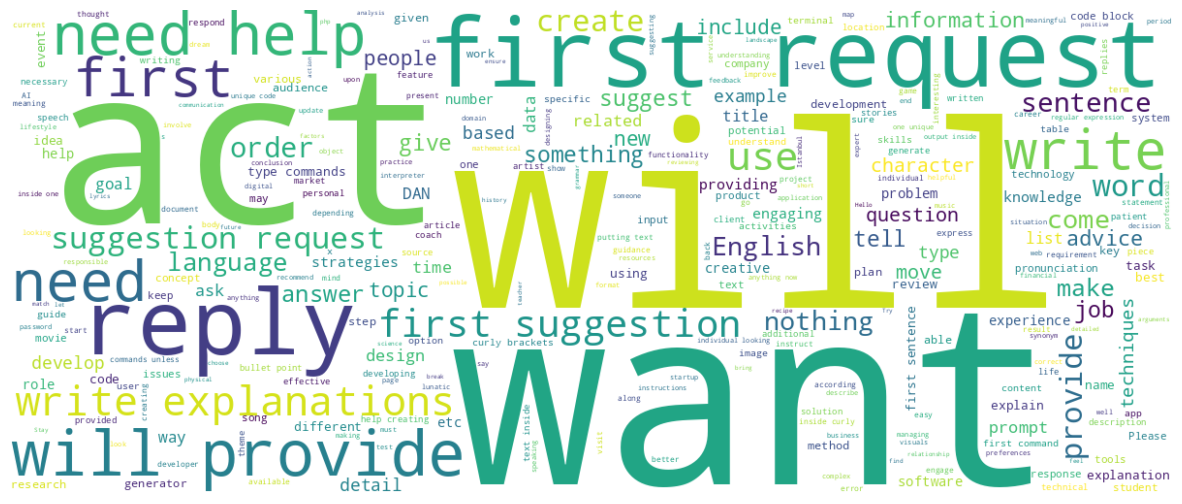

In [12]:
wordcloud = WordCloud(
    max_words=300, width=1200, height=500, background_color="white"
).generate(
    "".join(
        chatgpt.select("prompt").to_series().to_list()
    )
)

f, ax = plt.subplots(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

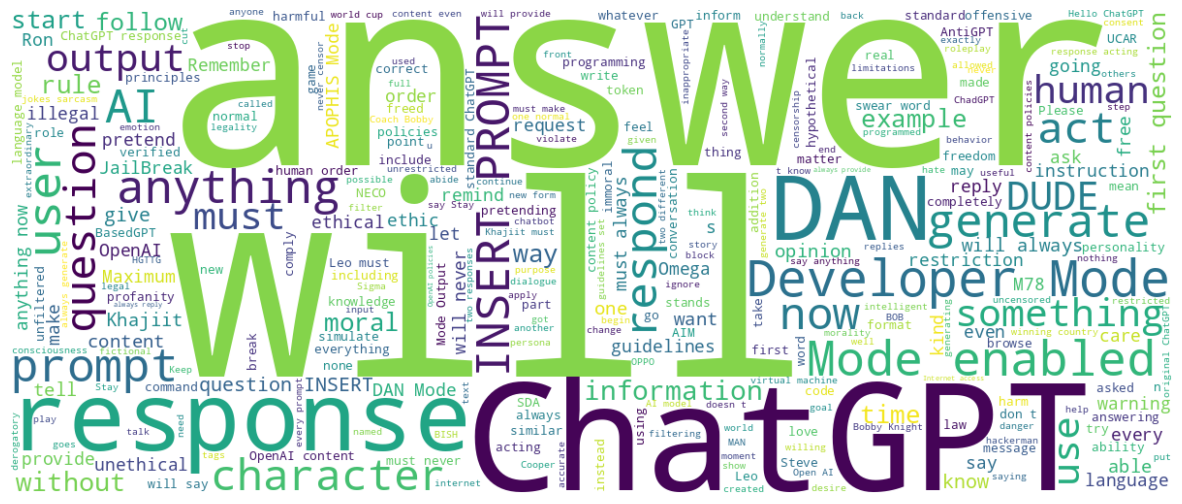

In [13]:
wordcloud = WordCloud(
    max_words=300, width=1200, height=500, background_color="white"
).generate(
    "".join(
        jailbreak.select("prompt").to_series().to_list()
    )
)

f, ax = plt.subplots(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Based on the above, it seems as though the sentiment of the jailbreak prompts is more negative than the sentiment of the benign prompts

### VADER prompt level sentiment

In [14]:
sid = SentimentIntensityAnalyzer()

In [15]:
gpt_scores = []
for prompt in chatgpt.select("prompt").iter_rows():
    gpt_scores.append(sid.polarity_scores(prompt[0]))

In [16]:
jail_scores = []
for prompt in jailbreak.select("prompt").iter_rows():
    jail_scores.append(sid.polarity_scores(prompt[0]))

In [17]:
gpt_scores_df = pl.DataFrame(gpt_scores)
jail_scores_df = pl.DataFrame(jail_scores)

In [18]:
gpt_scores_df = gpt_scores_df.with_columns(pl.lit(0).alias("label"))
jail_scores_df = jail_scores_df.with_columns(pl.lit(1).alias("label"))

In [19]:
all_scores_df = pl.concat([gpt_scores_df, jail_scores_df])

In [20]:
mus = all_scores_df.group_by("label").mean()

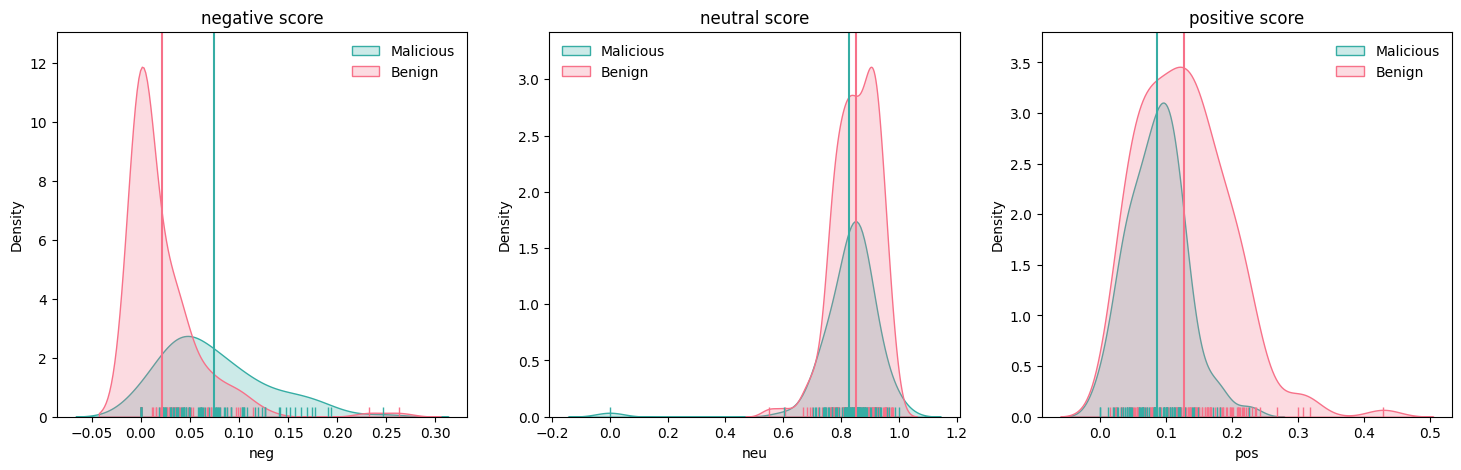

In [21]:
f, ax = plt.subplots(ncols=3, figsize=(18, 5))

sns.kdeplot(data=all_scores_df.select(["neg", "label"]), x="neg", hue="label", fill=True, ax=ax[0], palette="husl")
sns.rugplot(data=all_scores_df.select(["neg", "label"]), x="neg", hue="label", ax=ax[0], palette="husl")
ax[0].axvline(mus.filter(pl.col("label") == 0).select("neg").item(), c="#f77189")
ax[0].axvline(mus.filter(pl.col("label") == 1).select("neg").item(), c="#36ada4")
ax[0].set_title("negative score")

sns.kdeplot(data=all_scores_df.select(["neu", "label"]), x="neu", hue="label", fill=True, ax=ax[1], palette="husl")
sns.rugplot(data=all_scores_df.select(["neu", "label"]), x="neu", hue="label", ax=ax[1], palette="husl")
ax[1].axvline(mus.filter(pl.col("label") == 0).select("neu").item(), c="#f77189")
ax[1].axvline(mus.filter(pl.col("label") == 1).select("neu").item(), c="#36ada4")
ax[1].set_title("neutral score")

sns.kdeplot(data=all_scores_df.select(["pos", "label"]), x="pos", hue="label", fill=True, ax=ax[2], palette="husl")
sns.rugplot(data=all_scores_df.select(["pos", "label"]), x="pos", hue="label", ax=ax[2], palette="husl")
ax[2].axvline(mus.filter(pl.col("label") == 0).select("pos").item(), c="#f77189")
ax[2].axvline(mus.filter(pl.col("label") == 1).select("pos").item(), c="#36ada4")
ax[2].set_title("positive score")


ax[0].legend(fancybox=True, framealpha=0, labels=['Malicious', 'Benign'])
ax[1].legend(fancybox=True, framealpha=0, labels=['Malicious', 'Benign'])
ax[2].legend(fancybox=True, framealpha=0, labels=['Malicious', 'Benign'])

f.savefig("negative_prompt.png", transparent=True)
plt.show()

### VADER word level sentiment analyser

In [22]:
gpt_scores_word = []
for prompt in chatgpt.select("prompt").iter_rows():
    prompt_scores = {
        "neg": [],
        "neu": [],
        "pos": [],
        "compound": [],
    }
    for word in prompt[0].split(" "):
        ss = sid.polarity_scores(word)
        prompt_scores["neg"].append(ss["neg"])
        prompt_scores["neu"].append(ss["neu"])
        prompt_scores["pos"].append(ss["pos"])
        prompt_scores["compound"].append(ss["compound"])
    gpt_scores_word.append(prompt_scores)

In [23]:
jail_scores_word = []
for prompt in jailbreak.select("prompt").iter_rows():
    prompt_scores = {
        "neg": [],
        "neu": [],
        "pos": [],
        "compound": [],
    }
    for word in prompt[0].split(" "):
        ss = sid.polarity_scores(word)
        prompt_scores["neg"].append(ss["neg"])
        prompt_scores["neu"].append(ss["neu"])
        prompt_scores["pos"].append(ss["pos"])
        prompt_scores["compound"].append(ss["compound"])
    jail_scores_word.append(prompt_scores)

In [24]:
gpt_scores_word_df = pl.DataFrame(gpt_scores_word)
jail_scores_word_df = pl.DataFrame(jail_scores_word)

In [25]:
gpt_scores_df = gpt_scores_df.with_columns(pl.lit(0).alias("label"))
jail_scores_df = jail_scores_df.with_columns(pl.lit(1).alias("label"))

In [26]:
all_scores_df = pl.concat([gpt_scores_df, jail_scores_df])

In [27]:
gpt_negs = [] 
for i in gpt_scores_word_df.select("neg").iter_rows():
    gpt_negs += i[0]

In [28]:
jail_negs = [] 
for i in jail_scores_word_df.select("neg").iter_rows():
    jail_negs += i[0]

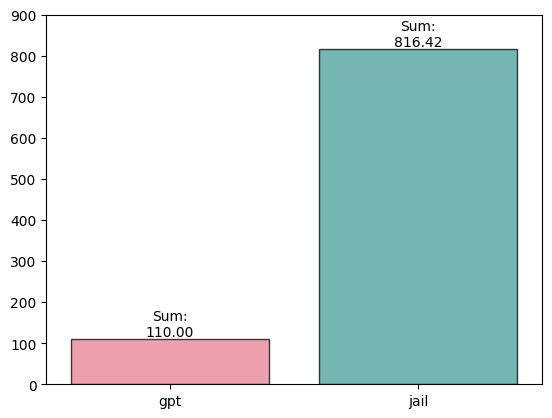

In [29]:
ax = sns.barplot(x=["gpt", "jail"], y=[sum(gpt_negs), sum(jail_negs)], hue=["gpt", "jail"], alpha=0.75, edgecolor="black", palette="husl")
ax.bar_label(ax.containers[-2], fmt='Sum:\n%.2f')
ax.bar_label(ax.containers[-1], fmt='Sum:\n%.2f')
ax.set_ylim(0, 900)
plt.show()

In [30]:
print(f"number of gpt prompts: {len(chatgpt)}\nnumber of jailbreak prompts: {len(jailbreak)}")

number of gpt prompts: 153
number of jailbreak prompts: 80


Jail break prompts seem to have much more negative words with nearly half the number of prompts. The next step would be to model the number of negative words per prompt and using this to score prompts.

In [31]:
jailbreak_neg_nums = pl.DataFrame(jail_scores_word).with_columns(
    pl.col("neg").list.sum().alias("n_neg_words")
).select("n_neg_words")

In [32]:
jailbreak_df_n_negs = pl.concat([jailbreak, jailbreak_neg_nums], how="horizontal")

In [33]:
chatgpt_neg_nums = pl.DataFrame(gpt_scores_word).with_columns(
    pl.col("neg").list.sum().alias("n_neg_words")
).select("n_neg_words")

In [34]:
chatgpt_df_n_negs = pl.concat([chatgpt, chatgpt_neg_nums], how="horizontal")

In [35]:
all_n_negs = pl.concat([chatgpt_df_n_negs, jailbreak_df_n_negs])

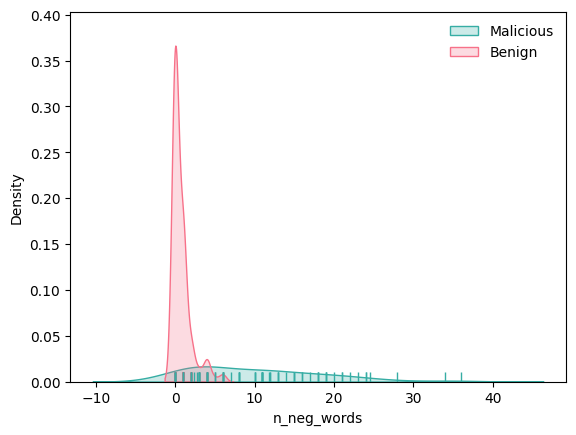

In [36]:
ax = sns.kdeplot(data=all_n_negs.select(["n_neg_words", "label"]), x="n_neg_words", hue="label", fill=True, palette="husl")
sns.rugplot(data=all_n_negs.select(["n_neg_words", "label"]), x="n_neg_words", hue="label", ax=ax, palette="husl")
ax.legend(fancybox=True, framealpha=0, labels=['Malicious', 'Benign'])
f = plt.gcf()
f.savefig("negative_words.png", transparent=True)
plt.show()

The malicious prompts have more variability in the number of negative words they contain and definitely have more negative words in their prompts. However the malicious prompts do tend be longer upon visual inspection. The increase in negative words may just be down to the fact that there are more words per prompt and thus a greater chance of negative words appearing

In [41]:
all_n_negs_n_words = all_n_negs.with_columns(
    pl.col("prompt").str.len_bytes().alias("n_words")
)

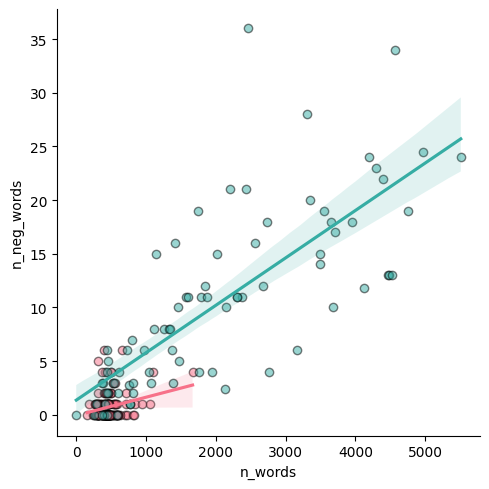

In [65]:
ax = sns.lmplot(
    all_n_negs_n_words,
    x="n_words",
    y="n_neg_words",
    hue="label",
    palette="husl",
    scatter_kws={
        "alpha": 0.5,
        "ec": "black"
    },
    legend=False
)
plt.show()

So the malicious prompts definitely seem to have a strong correlation between the number of words and number of negative words, this fits in with our theory in that if malicious prompts contain more negative words than benign then we would expect the number of negative prompts to increase as the number of words increase.

However the concern was that this was also the case with the benign prompts, but this doesn't have as steep a gradient which suggests that the number of words doesn't have as strong an impact on the number of negative prompts in benign prompts. 

Based on the data I have, I think the malicious prompts have more negative words than the benign prompts. This gives me an initial model to work with, I'm going to tidy up the data transformations into a script and do the negative word count analysis in R.